In [1]:
import argparse
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import torch
import wandb

wandb.init()

%load_ext autoreload
%autoreload 2

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sihany. Use `wandb login --relogin` to force relogin


In [2]:
torch.cuda.is_available()

True

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [49]:
model = Unet(
    dim = 128,
    dim_mults = (1, 2, 4)
).to(device=DEVICE)

diffusion = GaussianDiffusion(
    model,
    image_size =128,
    timesteps = 100,
    loss_type = 'l2'
).to(device=DEVICE)

In [50]:
args = {'dataset': 'desi_bgs'}
wandb.watch(diffusion, log_freq=100)

[]

In [60]:
diffusion.model.parameters()

AttributeError: 'GaussianDiffusion' object has no attribute 'model'

In [65]:
trainer = Trainer(
    diffusion,
    '/pscratch/sd/s/sihany/desiimages/',
    logdir = '/pscratch/sd/s/sihany/logs/desi/',
    image_size = 128,
    train_batch_size = 16,
    train_lr = 1e-4,
    train_num_steps = 1000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    save_every = 100,
    num_workers=32,
    rank = [0, 1, 2]
)

In [66]:
# trainer.load(100)

In [67]:
trainer.train()

0: 0.3582899570465088, delta_t: 8.036
0: 0.29423338174819946, delta_t: 7.393


sampling loop time step: 100%|██████████| 100/100 [00:01<00:00, 74.29it/s]


1: 3.7893147468566895, delta_t: 12.935
1: 3.2848291397094727, delta_t: 7.376
2: 1.3414838314056396, delta_t: 7.342
2: 1.1940256357192993, delta_t: 7.459
3: 0.7089914679527283, delta_t: 7.379
3: 0.9513286352157593, delta_t: 7.378
4: 0.6725392937660217, delta_t: 7.374
4: 0.7445243000984192, delta_t: 7.348
5: 0.9042925834655762, delta_t: 7.433
5: 0.7869672775268555, delta_t: 7.335
6: 0.5995258688926697, delta_t: 7.426
6: 0.45557406544685364, delta_t: 7.392
7: 0.671146810054779, delta_t: 7.370
7: 0.5167165994644165, delta_t: 7.469
8: 0.4902855455875397, delta_t: 7.473
8: 0.7761640548706055, delta_t: 7.365
9: 0.40478450059890747, delta_t: 7.521
9: 0.44693809747695923, delta_t: 7.373
10: 0.5339872241020203, delta_t: 7.390
10: 0.6703392863273621, delta_t: 7.488
11: 0.41331538558006287, delta_t: 7.401
11: 0.2876342236995697, delta_t: 7.465
12: 0.6738253831863403, delta_t: 7.384
12: 0.5391591787338257, delta_t: 7.391
13: 0.6065506935119629, delta_t: 7.389
13: 0.4331675171852112, delta_t: 7.405


In [68]:
# sample and plot

all_images = diffusion.sample(256, batch_size = 6)
all_images = (all_images + 1)/2
# all_images = list(map(lambda x: (x - 0)/(255 - 0), all_images))
all_images = torch.flip(all_images, dims=[1])*255 # map channels correctly for imout


sampling loop time step: 100%|██████████| 100/100 [00:02<00:00, 47.77it/s]


(array([1.220e+02, 1.611e+03, 7.264e+03, 5.697e+03, 1.332e+03, 2.630e+02,
        4.700e+01, 2.500e+01, 1.700e+01, 6.000e+00]),
 array([  0.        ,  24.31248856,  48.62497711,  72.93746185,
         97.24995422, 121.56243896, 145.87492371, 170.18740845,
        194.49990845, 218.81239319, 243.12487793]),
 <BarContainer object of 10 artists>)

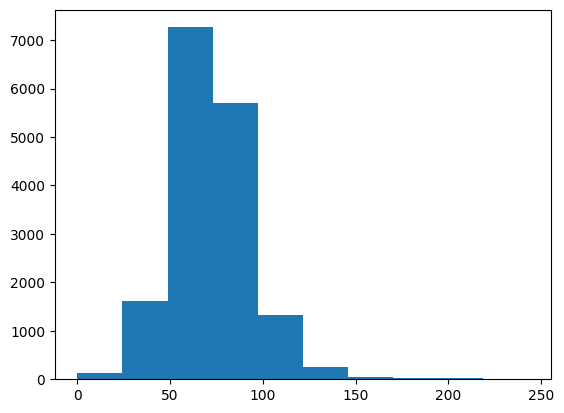

In [69]:
plt.hist(all_images[0].cpu()[0].flatten())

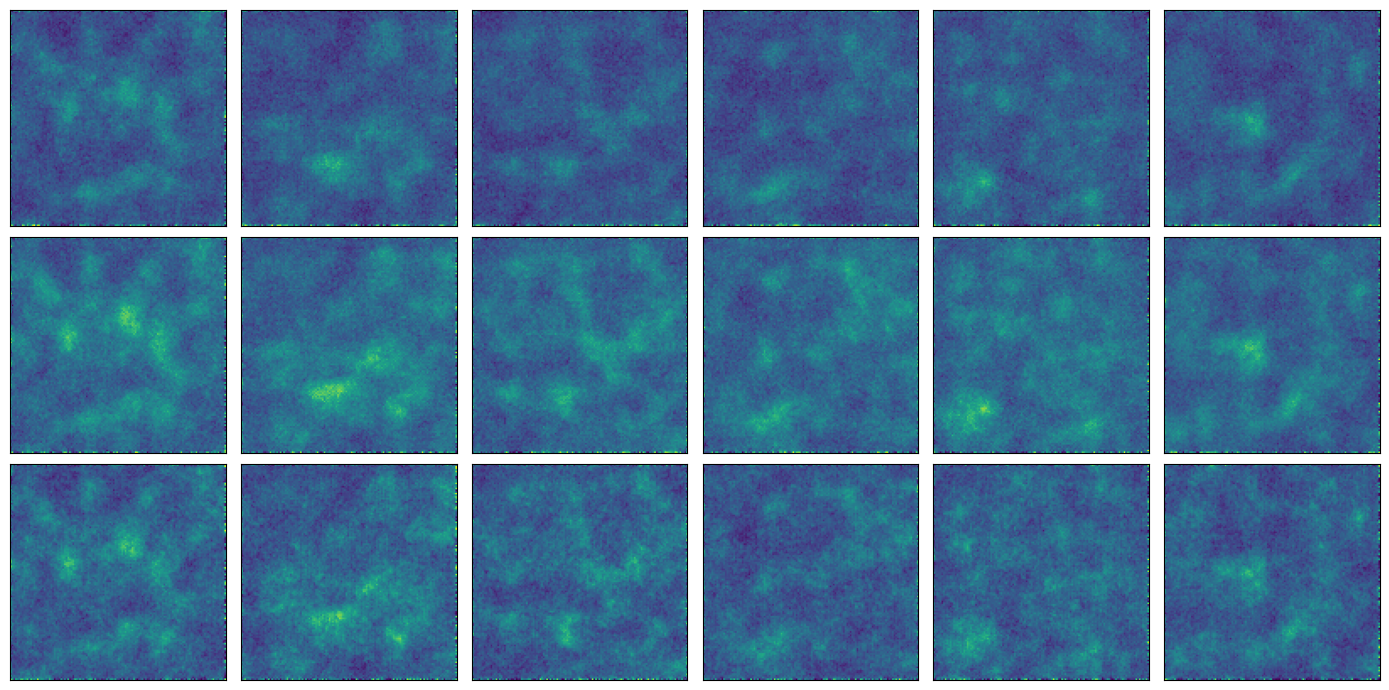

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (14, 7), ncols = 6, nrows = 3)
for i in range(6):
    # a = fits.open(fi)[0].data
    for jj in range(3):
        ax[jj][i].imshow(all_images[i].cpu()[jj,:,:])
        ax[jj][i].set_xticks([])
        ax[jj][i].set_yticks([])
    
plt.tight_layout()

# check images

In [44]:
fns = glob('/pscratch/sd/s/sihany/desiimages/*.npy')
np.load(fns[0]).shape

(3, 128, 128)

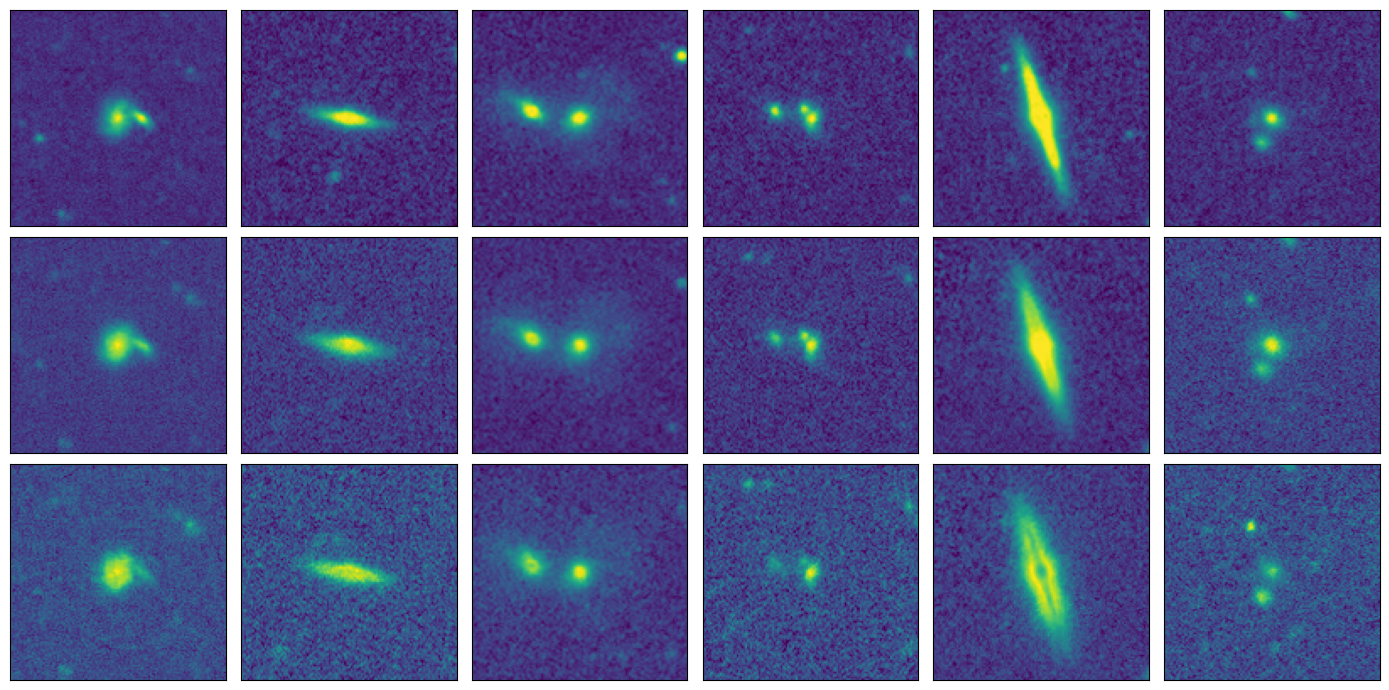

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from astropy.io import fits
from glob import glob
import random

catalog = fits.open('/pscratch/sd/v/virajvm/sandy_imgs/jura_bgs_N_20000.fits')[1].data
ids = catalog['TARGETID']
maskrflux = catalog['FLUX_R'] > 0
ids_sel = ids[maskrflux]

# fns = [f'/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_{eid}.jpg' for eid in ids_sel]

fns = glob('/pscratch/sd/s/sihany/desiimages/*.npy')

rfns = random.sample(fns, 6)

fig, ax = plt.subplots(figsize = (14, 7), ncols = 6, nrows = 3)
for i, fi in enumerate(rfns):
    # a = fits.open(fi)[0].data
    a = np.load(fi)
    # print(a, np.max(a), np.min(a))
    for jj in range(3):
        ax[jj][i].imshow(a[jj, :,:])
        ax[jj][i].set_xticks([])
        ax[jj][i].set_yticks([])
    
plt.tight_layout()


In [26]:
a

NameError: name 'a' is not defined

In [6]:
fns = [f'/pscratch/sd/v/virajvm/sandy_imgs/grz_cutouts_jpg/grz_dr9_id_39628065248123413.fits' for ename in [1,2,3]]

In [11]:
from os.path import basename
basename(fns[0])[11:-5]

'39628065248123413'